# Fundamentos de Sistemas Inteligentes en Visión  
Train your own traffic sign classifier from scratch.

- (c) MJMJ/2021 - University of Cordoba (original en inglés).
- (c) FJMC/2021 - Universidad de Córdoba (adaptación a español).  


In [ ]:
#Cargamos tensorflow que contiene a Keras.
import tensorflow as tf
# Conexión a Goolge Drive para descargar el dataset.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Decarga y preparción del Dataset.

In [ ]:
#creamos una carpeta local donde descargar el Dataset.
!mkdir /content/local

In [ ]:
# Descargar el dataset desde tu Google Drive.
# '/content/gdrive/MyDrive/' es la carpeta principal de tu dataset.
# Adapta el resto del camino convenientemente.

!cp 'gdrive/MyDrive/datasets/fsiv_gtscb_keras.zip' /content/local

In [ ]:
!ls

gdrive	local  sample_data


In [ ]:
# Unzip dataset
%cd /content/local/
!unzip /content/local/fsiv_gtscb_keras.zip

train_dir = '/content/local/fsiv_gtscb/train'

/content/local
Archive:  /content/local/fsiv_gtscb_keras.zip
   creating: fsiv_gtscb/
   creating: fsiv_gtscb/test/
  inflating: fsiv_gtscb/test/process.sh  
  inflating: fsiv_gtscb/test/process2.sh  
   creating: fsiv_gtscb/test/04/
 extracting: fsiv_gtscb/test/04/00093.png  
  inflating: fsiv_gtscb/test/04/00261.png  
 extracting: fsiv_gtscb/test/04/00353.png  
 extracting: fsiv_gtscb/test/04/00411.png  
 extracting: fsiv_gtscb/test/04/00132.png  
  inflating: fsiv_gtscb/test/04/00251.png  
  inflating: fsiv_gtscb/test/04/00224.png  
 extracting: fsiv_gtscb/test/04/00111.png  
  inflating: fsiv_gtscb/test/04/00303.png  
 extracting: fsiv_gtscb/test/04/00167.png  
  inflating: fsiv_gtscb/test/CLASSES.TXT  
   creating: fsiv_gtscb/test/06/
 extracting: fsiv_gtscb/test/06/00099.png  
 extracting: fsiv_gtscb/test/06/00174.png  
 extracting: fsiv_gtscb/test/06/00286.png  
 extracting: fsiv_gtscb/test/06/00081.png  
 extracting: fsiv_gtscb/test/06/00296.png  
 extracting: fsiv_gtscb/test/0

# Carga del Dataset usando Keras.

Para que podamos utilizar el Dataset Keras proporciona el método
[```preprocessing.image_dataset_from_directory()```](https://keras.io/api/preprocessing/image/#imagedatasetfromdirectory-function).

In [ ]:


#Esto son algunas variables que controlarán el proceso de entrenamiento.
batch_size = 32
img_height = 180
img_width = 180
train_dir = '/content/local/fsiv_gtscb/train/'
num_classes = 7
class_names = ['Prohibition', 'Warning', 'Diamond', 'Giveway', 'Stop',
               'EndProhibition', 'obligation']

# Cargar la partirción para entrenar.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Cargar la partirción para validar.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

print(train_ds.class_names)

Found 3487 files belonging to 7 classes.
Using 2790 files for training.
Found 3487 files belonging to 7 classes.
Using 697 files for validation.
['00', '01', '02', '03', '04', '05', '06']


Ahora, sólo para comprobar que todo va correctamente, vamos a visualizar algunos ejemplos de las muestras de entrenamiento.

Para ello vamos a utilizar el paquete matplotlib.

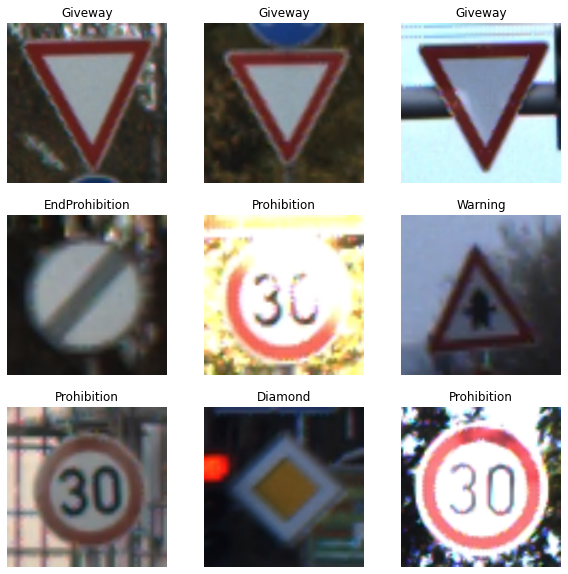

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i], axis=-1)])
    plt.axis("off")


# Creación del modelo.
Aquí debes definir una función para cada modelo de CNN que quieras probar.

Recuerda que la primera capa que debe tener un modelo es una capa que sirva como capa de entrada con una "forma" igual a las dimensiones de las imágenes usadas y que, tras los bloques convolucionales, vendrá un capa para "*aplanar*" el último nivel de las características extraídas por dichos bloques para conectar con una red neuronal densa final.

Revisa la documentación siguiente:
- [```tf.keras.Input```](https://keras.io/api/layers/core_layers/input/#input-function).
- [```tf.keras.layers.Conv2D```](https://keras.io/api/layers/convolution_layers/convolution2d/#conv2d-class).
- [```tf.keras.layers.Activation```](https://keras.io/api/layers/core_layers/activation/#activation-class)
- [```tf.keras.layers.MaxPool2D```](https://keras.io/api/layers/pooling_layers/max_pooling2d/#maxpooling2d-class).
- [```tf.keras.layers.AveragePooling2D```](https://keras.io/api/layers/pooling_layers/average_pooling2d/#averagepooling2d-class).
- [```tf.keras.layers.Flatten```](https://keras.io/api/layers/reshaping_layers/flatten/#flatten-class).
- [```tf.keras.layers.Dense```](https://keras.io/api/layers/core_layers/dense/#dense-class).
- Para otras capas consulta la documentación en [keras](https://keras.io/api/layers/#keras-layers-api).

In [ ]:
def create_model1_classic():
  '''
  Modelo 1. Modelo con un único bloque convolucional y una única capa densa oculta con 
            un número de neuronas igual al número de clases
  '''
  model = tf.keras.Sequential(      
      [#Capa de entrada
       tf.keras.Input(shape=(img_height, img_width, 3)),
       #Bloque : Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv1'),
       tf.keras.layers.Activation('relu', name='Relu1'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),
       #------
       #Flatten
       tf.keras.layers.Flatten(),
       #Red densa final. Debe terminar con una capa con tantas neuronas com clases 
       # y activación 'softmax'.
       tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense1')
       #
      ], name= 'Model1')
  return model

In [ ]:
def create_model2_classic():
  '''
  Modelo 2. Modelo con tres bloques convolucionales y una única capa densa oculta con 
            un número de neuronas igual al número de clases
  '''
  model = tf.keras.Sequential(      
      [#Capa de entrada
       tf.keras.Input(shape=(img_height, img_width, 3)),
       #Bloque 1 : Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv1'),
       tf.keras.layers.Activation('relu', name='Relu1'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),
       #------
       #Bloque 2 : Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv2'),
       tf.keras.layers.Activation('relu', name='Relu2'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool2'),
       #------
       #Bloque 3 : Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv3'),
       tf.keras.layers.Activation('relu', name='Relu3'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool3'),
       #------
       #Flatten
       tf.keras.layers.Flatten(),
       #Red densa final. Debe terminar con una capa con tantas neuronas com clases 
       # y activación 'softmax'.
       tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense1')
       #
      ], name= 'Model2')
  return model

In [ ]:
def create_model3_classic():
  '''
  Modelo 3. Modelo con un único bloque convolucional, una capa densa oculta con 
            un número de neuronas igual al número de clases y una capa densa con 100
            neuronas
  '''
  model = tf.keras.Sequential(      
      [#Capa de entrada
       tf.keras.Input(shape=(img_height, img_width, 3)),
       #Bloque : Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv1'),
       tf.keras.layers.Activation('relu', name='Relu1'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),
       #------
       #Flatten
       tf.keras.layers.Flatten(),
       #Red densa final. Debe terminar con una capa con 100 neuronas 
       # y activación 'relu'.
       tf.keras.layers.Dense(100, activation='relu', name='Dense1'),
       #Red densa final. Debe terminar con una capa con tantas neuronas com clases 
       # y activación 'softmax'.
       tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense2')
       #
      ], name= 'Model3')
  return model

In [ ]:
def create_model4_classic():
  '''
  Modelo 4. Modelo con un único bloque convolucional, una capa densa oculta con 
            un número de neuronas igual al número de clases y una capa densa con 100
            neuronas
  '''

  # Aplico pequeñas variaciones a las imágenes para que así entrene de forma mas genérica
  data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
  )

  model = tf.keras.Sequential(      
      [#Capa de entrada
       tf.keras.Input(shape=(img_height, img_width, 3)),
       # Distorsión tras la capa de entrada
       data_augmentation,
       #Bloque : Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(filters=20, kernel_size=5, padding='valid', name='Conv1'),
       tf.keras.layers.Activation('relu', name='Relu1'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),
       #------
       #Flatten
       tf.keras.layers.Flatten(),
       #Red densa final. Debe terminar con una capa con 100 neuronas 
       # y activación 'relu'.
       tf.keras.layers.Dense(100, activation='relu', name='Dense1'),
       #Red densa final. Debe terminar con una capa con tantas neuronas com clases 
       # y activación 'softmax'.
       tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense2')
       #
      ], name= 'Model4')
  return model

Ahora toca crear un modelo y compilarlo. Revisa la documentación de [```model.compile()```](https://keras.io/api/models/model_training_apis/#compile-method).

Recuerda que para compilar el modelo, debes indicar qué función de [pérdida](https://keras.io/api/losses/#losses) vas a utilizar y cuáles son las [métricas](https://keras.io/api/metrics/#metrics) usadas para evaluar.

También deberás indicar el algoritmo de descenso de gradiente. Se recomienda utilizar [```tf.keras.optimizers.SGD```](https://keras.io/api/optimizers/sgd/#sgd-class).

# Entramiento del modelo
Vamos a entrenar el modelo usando las particiones de ```train_ds``` y ```val_ds```.

Revisa la documentación de [```model.fit()```](https://keras.io/api/models/model_training_apis/#fit-method).


In [ ]:
!pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 4.8 MB/s 


# Extracción de la mejor variante del modelo 1

In [ ]:
import keras_tuner as keras_tuner

def create_model1(hp):
  '''
  Modelo 1. Modelo con un único bloque convolucional y una única capa densa oculta con 
            un número de neuronas igual al número de clases
  '''
  model = tf.keras.Sequential(      
      
      [#Capa de entrada
       tf.keras.Input(shape=(img_height, img_width, 3)),

       #Bloque : Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(
           
        # Para determinar el filtro realizaremos un proceso heurístico de la mejor variante dado este modelo
        # Empezaremos con un valor de 5 hasta un máximo de 25, escalando de 1 en 1    
        filters=hp.Int('conv_1_filter', min_value=5, max_value=25, step=1), 
    
        # Determinaremos el tamaño óptimo del kernel desde 2x2 a 5x5
        kernel_size=hp.Choice('conv_1_kernel', values=[2,5]),
        padding='valid', name='Conv1'),
       
       tf.keras.layers.Activation('relu', name='Relu1'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),

       #------
       #Flatten
       tf.keras.layers.Flatten(),

       #Red densa final. Debe terminar con una capa con tantas neuronas com clases 
       # y activación 'softmax'.
       tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense1')
       
      ], name= 'Model1')
  
  # TODO: Compila tu modelo. Por defecto teníamos el descenso del gradiente, pero he optado por
  # la variante adam por mejores resultados, realizando un progresivo decremento de learning rate
  model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics='accuracy')

  return model

In [ ]:
# TODO: Seleccionamos el mejor modelo a entrenar.
from keras_tuner import RandomSearch

tuner = RandomSearch(create_model1,
                    objective='val_accuracy',
                    max_trials=100)

# Buscamos los mejores hiperparámetros
tuner.search(train_ds, epochs=3, validation_data=val_ds)

#vamos a mostrar un resumen del modelo compilado. Observa el número de parámetros
# a entrenar

# Aquí obtendremos los mejores hiperparámetros para el modelo en cuestión
model=tuner.get_best_models(num_models=1)[0]

# Veremos el resumen del modelo final 
model.summary()

Trial 27 Complete [00h 00m 14s]
val_accuracy: 0.9139167666435242

Best val_accuracy So Far: 0.9971305727958679
Total elapsed time: 00h 07m 04s
INFO:tensorflow:Oracle triggered exit
Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 179, 179, 24)      312       
                                                                 
 Relu1 (Activation)          (None, 179, 179, 24)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 89, 89, 24)        0         
                                                                 
 flatten (Flatten)           (None, 190104)            0         
                                                                 
 Dense1 (Dense)              (None, 7)                 1330735   
                                                                 
Total param

In [ ]:
old_model = create_model1_classic()

old_model.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 176, 176, 20)      1520      
                                                                 
 Relu1 (Activation)          (None, 176, 176, 20)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 88, 88, 20)        0         
                                                                 
 flatten_1 (Flatten)         (None, 154880)            0         
                                                                 
 Dense1 (Dense)              (None, 7)                 1084167   
                                                                 
Total params: 1,085,687
Trainable params: 1,085,687
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Parámetros para entrenar el modelo
EPOCHS = 50
BATCH_SIZE = 100

# Early stopping en caso de que el modelo no mejore en las próximas 5 épocas
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

# Early stopping en caso de que reduciendo el ratio de aprendizaje no mejore

def scheduler(epoch, lr):
  '''
  Función que irá reduciendo el rating rate después de 10
  épocas
  '''
  if epoch % 10 != 0:
    return lr
  else:
    # Cada 10 épocas reduciremos el learning rate
    return lr * tf.exp(-0.1)


callback_learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# TODO Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[callback_early_stopping]
)


Epoch 1/50
88/88 [==============================] - 5s 51ms/step - loss: 1.9384 - accuracy: 0.9860 - val_loss: 1.7267 - val_accuracy: 0.9842
Epoch 2/50
88/88 [==============================] - 4s 47ms/step - loss: 1.0788 - accuracy: 0.9921 - val_loss: 1.7528 - val_accuracy: 0.9842
Epoch 3/50
88/88 [==============================] - 4s 46ms/step - loss: 0.9763 - accuracy: 0.9939 - val_loss: 0.4775 - val_accuracy: 0.9971
Epoch 4/50
88/88 [==============================] - 4s 47ms/step - loss: 0.3289 - accuracy: 0.9971 - val_loss: 0.6661 - val_accuracy: 0.9928
Epoch 5/50
88/88 [==============================] - 4s 47ms/step - loss: 1.5853 - accuracy: 0.9903 - val_loss: 2.4216 - val_accuracy: 0.9871
Epoch 6/50
88/88 [==============================] - 4s 46ms/step - loss: 1.1470 - accuracy: 0.9910 - val_loss: 1.3135 - val_accuracy: 0.9885
Epoch 7/50
88/88 [==============================] - 4s 46ms/step - loss: 0.8152 - accuracy: 0.9925 - val_loss: 4.5562 - val_accuracy: 0.9627
Epoch 8/50
88

##Generar gráficas de evalución de la pérdida y métrica.

Vamos a generar un gráfica con la evalución de la función de pérdida y métrica.

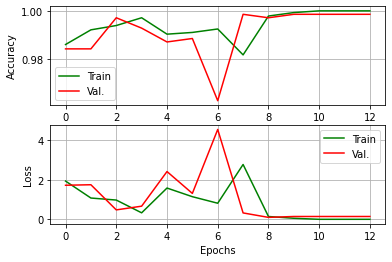

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].grid(True)
axes[0].set_ylabel('Accuracy')
axes[0].plot(history.history['accuracy'], 'g-', label='Train')
axes[0].plot(history.history['val_accuracy'], 'r-', label='Val.')
axes[0].legend()
axes[1].grid(True)
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].plot(history.history['loss'], 'g-', label='Train')
axes[1].plot(history.history['val_loss'], 'r-', label='Val.')
axes[1].legend()

In [ ]:
from google.colab import files

fig.savefig("model_fig.png")
files.download("model_fig.png") 

Si consideras que el resultado de este modelo vale la pena, puedes guardar el modelo para recuperarlo después (para aplicar en *test*).

In [ ]:
!ls '/content/gdrive/MyDrive/FSIV_MODELS'

In [ ]:
# Actualiza el camino y el nombre del fichero de forma acorde.
model_path = '/content/gdrive/MyDrive/FSIV_MODELS/traffic_classif_model1.h5'
model.save(model_path)

# Extracción de la mejor variante del modelo 2

In [ ]:
import keras_tuner as keras_tuner

def create_model2(hp):
  '''
  Modelo 2. Modelo tres bloques convolucionales y una única capa densa oculta con 
            un número de neuronas igual al número de clases
  '''
  model = tf.keras.Sequential(      
      
      [#Capa de entrada
       tf.keras.Input(shape=(img_height, img_width, 3)),

       #Bloque 1: Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(
           
        # Para determinar el filtro realizaremos un proceso heurístico de la mejor variante dado este modelo
        # Empezaremos con un valor de 5 hasta un máximo de 25, escalando de 1 en 1    
        filters=hp.Int('conv_1_filter', min_value=5, max_value=25, step=1), 
    
        # Determinaremos el tamaño óptimo del kernel desde 2x2 a 5x5
        kernel_size=hp.Choice('conv_1_kernel', values=[2,5]),
        padding='valid', name='Conv1'),
       
       tf.keras.layers.Activation('relu', name='Relu1'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),

       #Bloque 2: Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(
           
        # Para determinar el filtro realizaremos un proceso heurístico de la mejor variante dado este modelo
        # Empezaremos con un valor de 5 hasta un máximo de 25, escalando de 1 en 1    
        filters=hp.Int('conv_2_filter', min_value=5, max_value=25, step=1), 
    
        # Determinaremos el tamaño óptimo del kernel desde 2x2 a 5x5
        kernel_size=hp.Choice('conv_2_kernel', values=[2,5]),
        padding='valid', name='Conv2'),
       
        tf.keras.layers.Activation('relu', name='Relu2'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool2'),

       #Bloque 3: Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(
           
        # Para determinar el filtro realizaremos un proceso heurístico de la mejor variante dado este modelo
        # Empezaremos con un valor de 5 hasta un máximo de 25, escalando de 1 en 1    
        filters=hp.Int('conv_3_filter', min_value=5, max_value=25, step=1), 
    
        # Determinaremos el tamaño óptimo del kernel desde 2x2 a 5x5
        kernel_size=hp.Choice('conv_3_kernel', values=[2,5]),
        padding='valid', name='Conv3'),
       
       tf.keras.layers.Activation('relu', name='Relu3'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool3'),

       #------
       #Flatten
       tf.keras.layers.Flatten(),

       #Red densa final. Debe terminar con una capa con tantas neuronas com clases 
       # y activación 'softmax'.
       tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense1')
       
      ], name= 'Model2')
  
  # TODO: Compila tu modelo. Por defecto teníamos el descenso del gradiente, pero he optado por
  # la variante adam por mejores resultados, realizando un progresivo decremento de learning rate
  model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics='accuracy')

  return model

In [ ]:
# TODO: Seleccionamos el mejor modelo a entrenar.
from keras_tuner import RandomSearch

tuner = RandomSearch(create_model2,
                    objective='val_accuracy',
                    max_trials=100)

# Buscamos los mejores hiperparámetros
tuner.search(train_ds, epochs=3, validation_data=val_ds)

#vamos a mostrar un resumen del modelo compilado. Observa el número de parámetros
# a entrenar

# Aquí obtendremos los mejores hiperparámetros para el modelo en cuestión
model=tuner.get_best_models(num_models=1)[0]

# Veremos el resumen del modelo final 
model.summary()

Trial 500 Complete [00h 00m 14s]
val_accuracy: 0.9956958293914795

Best val_accuracy So Far: 1.0
Total elapsed time: 02h 37m 41s
INFO:tensorflow:Oracle triggered exit
Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 179, 179, 8)       104       
                                                                 
 Relu1 (Activation)          (None, 179, 179, 8)       0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 89, 89, 8)         0         
                                                                 
 Conv2 (Conv2D)              (None, 85, 85, 18)        3618      
                                                                 
 Relu2 (Activation)          (None, 85, 85, 18)        0         
                                                                 
 Pool2 (MaxPooling2D)    

In [ ]:
old_model = create_model2_classic()

old_model.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 176, 176, 20)      1520      
                                                                 
 Relu1 (Activation)          (None, 176, 176, 20)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 88, 88, 20)        0         
                                                                 
 Conv2 (Conv2D)              (None, 84, 84, 20)        10020     
                                                                 
 Relu2 (Activation)          (None, 84, 84, 20)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 42, 42, 20)        0         
                                                                 
 Conv3 (Conv2D)              (None, 38, 38, 20)        10020

In [ ]:
# Parámetros para entrenar el modelo
EPOCHS = 50
BATCH_SIZE = 100

# Early stopping en caso de que el modelo no mejore en las próximas 5 épocas
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

# Early stopping en caso de que reduciendo el ratio de aprendizaje no mejore

def scheduler(epoch, lr):
  '''
  Función que irá reduciendo el rating rate después de 10
  épocas
  '''
  if epoch % 10 != 0:
    return lr
  else:
    # Cada 10 épocas reduciremos el learning rate
    return lr * tf.exp(-0.1)


callback_learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# TODO Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[callback_early_stopping]
)

Epoch 1/50
88/88 [==============================] - 5s 51ms/step - loss: 0.0139 - accuracy: 0.9982 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 2/50
88/88 [==============================] - 5s 50ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 3/50
88/88 [==============================] - 5s 49ms/step - loss: 8.8525e-04 - accuracy: 1.0000 - val_loss: 9.3858e-04 - val_accuracy: 1.0000
Epoch 4/50
88/88 [==============================] - 5s 50ms/step - loss: 6.2273e-04 - accuracy: 1.0000 - val_loss: 7.6411e-04 - val_accuracy: 1.0000
Epoch 5/50
88/88 [==============================] - 5s 57ms/step - loss: 4.8696e-04 - accuracy: 1.0000 - val_loss: 6.3133e-04 - val_accuracy: 1.0000
Epoch 6/50
88/88 [==============================] - 7s 72ms/step - loss: 3.8567e-04 - accuracy: 1.0000 - val_loss: 5.0999e-04 - val_accuracy: 1.0000


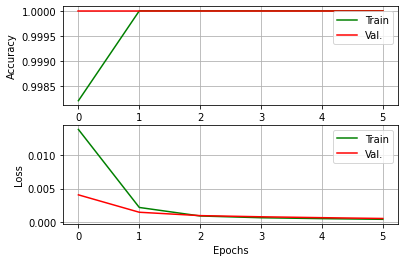

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].grid(True)
axes[0].set_ylabel('Accuracy')
axes[0].plot(history.history['accuracy'], 'g-', label='Train')
axes[0].plot(history.history['val_accuracy'], 'r-', label='Val.')
axes[0].legend()
axes[1].grid(True)
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].plot(history.history['loss'], 'g-', label='Train')
axes[1].plot(history.history['val_loss'], 'r-', label='Val.')
axes[1].legend()

In [ ]:
from google.colab import files

fig.savefig("model_fig2.png")
files.download("model_fig2.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls '/content/gdrive/MyDrive/FSIV_MODELS'

traffic_classif_model1.h5  traffic_classif_model2.h5


In [ ]:
# Actualiza el camino y el nombre del fichero de forma acorde.
model_path = '/content/gdrive/MyDrive/FSIV_MODELS/traffic_classif_model2.h5'
model.save(model_path)

# Extracción de la mejor variante del modelo 3


In [ ]:
import keras_tuner as keras_tuner

def create_model3(hp):
  '''
  Modelo 3. Modelo con un único bloque convolucional, una capa densa oculta con 
            un número de neuronas igual al número de clases y una capa densa con 
            N neuronas a determinar.
  '''
  model = tf.keras.Sequential(      
      
      [#Capa de entrada
       tf.keras.Input(shape=(img_height, img_width, 3)),

       #Bloque : Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(
           
        # Para determinar el filtro realizaremos un proceso heurístico de la mejor variante dado este modelo
        # Empezaremos con un valor de 5 hasta un máximo de 25, escalando de 1 en 1    
        filters=hp.Int('conv_1_filter', min_value=5, max_value=25, step=1), 
    
        # Determinaremos el tamaño óptimo del kernel desde 2x2 a 5x5
        kernel_size=hp.Choice('conv_1_kernel', values=[2,5]),
        padding='valid', name='Conv1'),
       
       tf.keras.layers.Activation('relu', name='Relu1'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),

       #------
       #Flatten
       tf.keras.layers.Flatten(),

       #Red densa final. Debe terminar con una capa con N neuronas (determinaremos cual valor obtiene el mejor modelo)
       # y activación 'relu'.
       tf.keras.layers.Dense(hp.Int('Dense1', min_value=10, max_value=150, step=10),
                              activation='relu', name='Dense1'),

       #Red densa final. Debe terminar con una capa con tantas neuronas com clases 
       # y activación 'softmax'.
       tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense2')
       
      ], name= 'Model3')
  
  # TODO: Compila tu modelo. Por defecto teníamos el descenso del gradiente, pero he optado por
  # la variante adam por mejores resultados, realizando un progresivo decremento de learning rate
  model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics='accuracy')

  return model

In [ ]:
# TODO: Seleccionamos el mejor modelo a entrenar.
from keras_tuner import RandomSearch

tuner = RandomSearch(create_model3,
                    objective='val_accuracy',
                    max_trials=100)

# Buscamos los mejores hiperparámetros
tuner.search(train_ds, epochs=3, validation_data=val_ds)

#vamos a mostrar un resumen del modelo compilado. Observa el número de parámetros
# a entrenar

# Aquí obtendremos los mejores hiperparámetros para el modelo en cuestión
model=tuner.get_best_models(num_models=1)[0]

# Veremos el resumen del modelo final 
model.summary()

Trial 100 Complete [00h 00m 23s]
val_accuracy: 0.9727402925491333

Best val_accuracy So Far: 0.9985652565956116
Total elapsed time: 00h 42m 03s
INFO:tensorflow:Oracle triggered exit
Model: "Model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 179, 179, 25)      325       
                                                                 
 Relu1 (Activation)          (None, 179, 179, 25)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 89, 89, 25)        0         
                                                                 
 flatten (Flatten)           (None, 198025)            0         
                                                                 
 Dense1 (Dense)              (None, 60)                11881560  
                                                                 
 Dense2 (D

In [ ]:
old_model = create_model3_classic()

old_model.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 176, 176, 20)      1520      
                                                                 
 Relu1 (Activation)          (None, 176, 176, 20)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 88, 88, 20)        0         
                                                                 
 flatten_3 (Flatten)         (None, 154880)            0         
                                                                 
 Dense1 (Dense)              (None, 100)               15488100  
                                                                 
 Dense2 (Dense)              (None, 7)                 707       
                                                                 
Total params: 15,490,327
Trainable params: 15,490,327
Non-tr

In [ ]:
# Parámetros para entrenar el modelo
EPOCHS = 50
BATCH_SIZE = 100

# Early stopping en caso de que el modelo no mejore en las próximas 5 épocas
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

# Early stopping en caso de que reduciendo el ratio de aprendizaje no mejore

def scheduler(epoch, lr):
  '''
  Función que irá reduciendo el rating rate después de 10
  épocas
  '''
  if epoch % 10 != 0:
    return lr
  else:
    # Cada 10 épocas reduciremos el learning rate
    return lr * tf.exp(-0.1)


callback_learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# TODO Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[callback_early_stopping]
)

Epoch 1/50
88/88 [==============================] - 7s 72ms/step - loss: 4.1406 - accuracy: 0.9473 - val_loss: 1.3481 - val_accuracy: 0.9799
Epoch 2/50
88/88 [==============================] - 8s 83ms/step - loss: 4.4242 - accuracy: 0.9516 - val_loss: 6.2158 - val_accuracy: 0.9541
Epoch 3/50
88/88 [==============================] - 6s 71ms/step - loss: 5.4288 - accuracy: 0.9602 - val_loss: 7.0010 - val_accuracy: 0.9354
Epoch 4/50
88/88 [==============================] - 6s 61ms/step - loss: 2.6883 - accuracy: 0.9685 - val_loss: 1.4105 - val_accuracy: 0.9857
Epoch 5/50
88/88 [==============================] - 7s 74ms/step - loss: 3.0905 - accuracy: 0.9670 - val_loss: 0.6826 - val_accuracy: 0.9900
Epoch 6/50
88/88 [==============================] - 6s 63ms/step - loss: 2.2439 - accuracy: 0.9778 - val_loss: 0.0889 - val_accuracy: 0.9957
Epoch 7/50
88/88 [==============================] - 7s 74ms/step - loss: 1.9683 - accuracy: 0.9824 - val_loss: 1.1299 - val_accuracy: 0.9813
Epoch 8/50
88

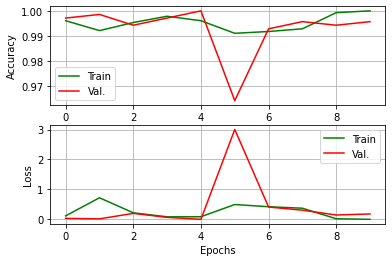

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].grid(True)
axes[0].set_ylabel('Accuracy')
axes[0].plot(history.history['accuracy'], 'g-', label='Train')
axes[0].plot(history.history['val_accuracy'], 'r-', label='Val.')
axes[0].legend()
axes[1].grid(True)
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].plot(history.history['loss'], 'g-', label='Train')
axes[1].plot(history.history['val_loss'], 'r-', label='Val.')
axes[1].legend()

In [ ]:
from google.colab import files

fig.savefig("model_fig3.png")
files.download("model_fig3.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls '/content/gdrive/MyDrive/FSIV_MODELS'

traffic_classif_model1.h5  traffic_classif_model2.h5


In [ ]:
# Actualiza el camino y el nombre del fichero de forma acorde.
model_path = '/content/gdrive/MyDrive/FSIV_MODELS/traffic_classif_model3.h5'
model.save(model_path)

# Extracción de la mejor variante del modelo 4


In [ ]:
import keras_tuner as keras_tuner

def create_model4(hp):
  '''
  Modelo 4. Modelo con un único bloque convolucional y una única capa densa oculta con 
            un número de neuronas igual al número de clases
  '''

  # Aplico pequeñas variaciones a las imágenes para que así entrene de forma mas genérica
  data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
  )

  model = tf.keras.Sequential(      
      [#Capa de entrada
       tf.keras.Input(shape=(img_height, img_width, 3)),

        # Distorsión de los datos de entrada
       data_augmentation,

       #Bloque : Conv --> Relu --> Pool
       tf.keras.layers.Conv2D(
           
        # Para determinar el filtro realizaremos un proceso heurístico de la mejor variante dado este modelo
        # Empezaremos con un valor de 5 hasta un máximo de 25, escalando de 1 en 1    
        filters=hp.Int('conv_1_filter', min_value=5, max_value=25, step=1), 
    
        # Determinaremos el tamaño óptimo del kernel desde 2x2 a 5x5
        kernel_size=hp.Choice('conv_1_kernel', values=[2,5]),
        padding='valid', name='Conv1'),
       
       tf.keras.layers.Activation('relu', name='Relu1'),
       tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name='Pool1'),

       #------
       #Flatten
       tf.keras.layers.Flatten(),

       #Red densa final. Debe terminar con una capa con N neuronas (determinaremos cual valor obtiene el mejor modelo)
       # y activación 'relu'.
       tf.keras.layers.Dense(hp.Int('Dense1', min_value=10, max_value=150, step=10),
                              activation='relu', name='Dense1'),

       #Red densa final. Debe terminar con una capa con tantas neuronas com clases 
       # y activación 'softmax'.
       tf.keras.layers.Dense(num_classes, activation='softmax', name='Dense2')
       
      ], name= 'Model4')
  
  # TODO: Compila tu modelo. Por defecto teníamos el descenso del gradiente, pero he optado por
  # la variante adam por mejores resultados, realizando un progresivo decremento de learning rate
  model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics='accuracy')

  return model

In [ ]:
# TODO: Seleccionamos el mejor modelo a entrenar.
from keras_tuner import RandomSearch

tuner = RandomSearch(create_model4,
                    objective='val_accuracy',
                    max_trials=100)

# Buscamos los mejores hiperparámetros
tuner.search(train_ds, epochs=3, validation_data=val_ds)

#vamos a mostrar un resumen del modelo compilado. Observa el número de parámetros
# a entrenar

# Aquí obtendremos los mejores hiperparámetros para el modelo en cuestión
model=tuner.get_best_models(num_models=1)[0]

# Veremos el resumen del modelo final 
model.summary()

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "Model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 Conv1 (Conv2D)              (None, 179, 179, 12)      156       
                                                                 
 Relu1 (Activation)          (None, 179, 179, 12)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 89, 89, 12)        0         
                                                                 
 flatten (Flatten)           (None, 95052)             0         
                                                                 


In [ ]:
old_model = create_model4_classic()

old_model.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 Conv1 (Conv2D)              (None, 176, 176, 20)      1520      
                                                                 
 Relu1 (Activation)          (None, 176, 176, 20)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 88, 88, 20)        0         
                                                                 
 flatten_4 (Flatten)         (None, 154880)            0         
                                                                 
 Dense1 (Dense)              (None, 100)               15488100  
                                                                 
 Dense2 (Dense)              (None, 7)                 707  

In [ ]:
# Parámetros para entrenar el modelo
EPOCHS = 50
BATCH_SIZE = 100

# Early stopping en caso de que el modelo no mejore en las próximas 5 épocas
callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

# Early stopping en caso de que reduciendo el ratio de aprendizaje no mejore

def scheduler(epoch, lr):
  '''
  Función que irá reduciendo el rating rate después de 10
  épocas
  '''
  if epoch % 10 != 0:
    return lr
  else:
    # Cada 10 épocas reduciremos el learning rate
    return lr * tf.exp(-0.1)


callback_learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# TODO Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[callback_early_stopping]
)

Epoch 1/50
88/88 [==============================] - 7s 71ms/step - loss: 8.1326 - accuracy: 0.9290 - val_loss: 1.4863 - val_accuracy: 0.9857
Epoch 2/50
88/88 [==============================] - 10s 114ms/step - loss: 6.9352 - accuracy: 0.9484 - val_loss: 1.1762 - val_accuracy: 0.9770
Epoch 3/50
88/88 [==============================] - 10s 106ms/step - loss: 8.4965 - accuracy: 0.9405 - val_loss: 1.6922 - val_accuracy: 0.9857
Epoch 4/50
88/88 [==============================] - 7s 72ms/step - loss: 1.9752 - accuracy: 0.9789 - val_loss: 0.6340 - val_accuracy: 0.9885
Epoch 5/50
88/88 [==============================] - 5s 56ms/step - loss: 2.6900 - accuracy: 0.9713 - val_loss: 1.4482 - val_accuracy: 0.9770
Epoch 6/50
88/88 [==============================] - 7s 75ms/step - loss: 0.9510 - accuracy: 0.9875 - val_loss: 0.4068 - val_accuracy: 0.9943
Epoch 7/50
88/88 [==============================] - 6s 70ms/step - loss: 0.7783 - accuracy: 0.9857 - val_loss: 0.0020 - val_accuracy: 0.9986
Epoch 8/5

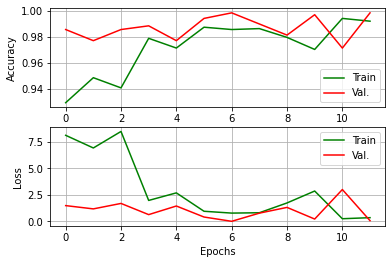

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].grid(True)
axes[0].set_ylabel('Accuracy')
axes[0].plot(history.history['accuracy'], 'g-', label='Train')
axes[0].plot(history.history['val_accuracy'], 'r-', label='Val.')
axes[0].legend()
axes[1].grid(True)
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].plot(history.history['loss'], 'g-', label='Train')
axes[1].plot(history.history['val_loss'], 'r-', label='Val.')
axes[1].legend()

In [ ]:
from google.colab import files

fig.savefig("model_fig4.png")
files.download("model_fig4.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls '/content/gdrive/MyDrive/FSIV_MODELS'

traffic_classif_model1.h5  traffic_classif_model2.h5  traffic_classif_model3.h5


In [ ]:
# Actualiza el camino y el nombre del fichero de forma acorde.
model_path = '/content/gdrive/MyDrive/FSIV_MODELS/traffic_classif_model4.h5'
model.save(model_path)

# Evaluación del modelo sobre la partición de test.

Ahora toca evaluar el mejor modelo conseguido con la partición de test.

Lo primero será cargar la partición de "test".

In [ ]:
test_dir = '/content/local/fsiv_gtscb/test/'
# Cargar la partirción para entrenar.
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  labels='inferred',
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 70 files belonging to 7 classes.


Ahora cargamos desde el fichero los pesos entrenados del modelo a evaluar con [```tf.keras.models.load_model()```](https://keras.io/api/models/model_saving_apis/#loadmodel-function).

In [ ]:
#Esta celda no la ejecutas si sólo quieres comprobar el modelo que acabas de entrenar.
#Ajusta el path segun el modelo a evaluar.
model_path_1 = '/content/gdrive/MyDrive/FSIV_MODELS/traffic_classif_model1.h5'
model_1 = tf.keras.models.load_model(model_path_1)

model_path_2 = '/content/gdrive/MyDrive/FSIV_MODELS/traffic_classif_model2.h5'
model_2 = tf.keras.models.load_model(model_path_2)

model_path_3 = '/content/gdrive/MyDrive/FSIV_MODELS/traffic_classif_model3.h5'
model_3 = tf.keras.models.load_model(model_path_3)

model_path_4 = '/content/gdrive/MyDrive/FSIV_MODELS/traffic_classif_model4.h5'
model_4 = tf.keras.models.load_model(model_path_4)

y ahora toca evaluar el modelo con el método [```model.evaluate()```](https://keras.io/api/models/model_training_apis/#evaluate-method).

In [ ]:
model_1.summary()

#TODO: evaluar el modelo 1.
score = model_1.evaluate(test_ds)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

model_2.summary()

#TODO: evaluar el modelo 2.
score = model_2.evaluate(test_ds)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

model_3.summary()

#TODO: evaluar el modelo.
score = model_3.evaluate(test_ds)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

model_4.summary()

#TODO: evaluar el modelo.
score = model_4.evaluate(test_ds)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 179, 179, 16)      208       
                                                                 
 Relu1 (Activation)          (None, 179, 179, 16)      0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 89, 89, 16)        0         
                                                                 
 flatten (Flatten)           (None, 126736)            0         
                                                                 
 Dense1 (Dense)              (None, 7)                 887159    
                                                                 
Total params: 887,367
Trainable params: 887,367
Non-trainable params: 0
_________________________________________________________________
3/3 [==============================] - 0s 15ms/step - 

Dado que el **modelo 2** es el modelo más interesante, dado el alto valor de acuraccy y el bajo valor de loss que hemos obtenido en la partición de validación, además del reducido peso que tiene el mismo, vamos a intentar optimizarlo al máximo, entrenándolo lo suficiente para reducir **val_loss** lo máximo que podamos. Para ello usaremos un checkpoint el cual guarde el mejor modelo obtenido, y un callback earlystopping, con una paciencia de 5 épocas.

In [ ]:
from keras.callbacks import ModelCheckpoint

callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/FSIV_MODELS/best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

EPOCHS = 100

history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[callback_early_stopping, model_checkpoint]
)

Epoch 1/100
86/88 [============================>.] - ETA: 0s - loss: 0.4119 - accuracy: 0.9382
Epoch 00001: val_loss improved from inf to 0.08270, saving model to /content/gdrive/MyDrive/FSIV_MODELS/best_model.h5
88/88 [==============================] - 6s 53ms/step - loss: 0.4083 - accuracy: 0.9387 - val_loss: 0.0827 - val_accuracy: 0.9828
Epoch 2/100
86/88 [============================>.] - ETA: 0s - loss: 0.0178 - accuracy: 0.9945
Epoch 00002: val_loss improved from 0.08270 to 0.00966, saving model to /content/gdrive/MyDrive/FSIV_MODELS/best_model.h5
88/88 [==============================] - 5s 51ms/step - loss: 0.0176 - accuracy: 0.9946 - val_loss: 0.0097 - val_accuracy: 0.9986
Epoch 3/100
87/88 [============================>.] - ETA: 0s - loss: 5.1306e-04 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.00966 to 0.00914, saving model to /content/gdrive/MyDrive/FSIV_MODELS/best_model.h5
88/88 [==============================] - 5s 51ms/step - loss: 5.1196e-04 - accuracy: 1.00

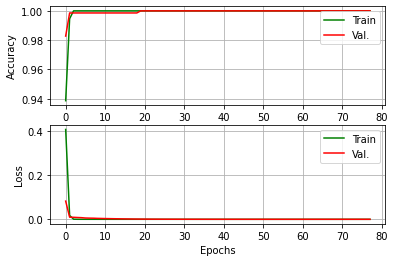

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].grid(True)
axes[0].set_ylabel('Accuracy')
axes[0].plot(history.history['accuracy'], 'g-', label='Train')
axes[0].plot(history.history['val_accuracy'], 'r-', label='Val.')
axes[0].legend()
axes[1].grid(True)
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].plot(history.history['loss'], 'g-', label='Train')
axes[1].plot(history.history['val_loss'], 'r-', label='Val.')
axes[1].legend()

In [ ]:
from google.colab import files

fig.savefig("best_model.png")
files.download("best_model.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
best_model = tf.keras.models.load_model('/content/gdrive/MyDrive/FSIV_MODELS/best_model.h5')

score = best_model.evaluate(test_ds)
print("Test loss:", score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 18ms/step - loss: 0.0419 - accuracy: 0.9857
Test loss: 0.041938479989767075
Test accuracy: 0.9857142567634583


Podemos observar que el modelo final ofrece muy buenos resultados.

# Aplicación de un modelo sobre imágenes reales.
Para evaluar el modelo sobre imágenes de test obtenidas desde internet, deberías primero cargarlas desde internet, seleccionar la region de interés con la señal a clasificar, redimensionar la ROI al tamaño usado para entrenar el modelo y aplicar el modelo con [```model.predit()```](https://keras.io/api/models/model_training_apis/#predict-method).


In [ ]:
#Ajusta el path segun el modelo a evaluar.
model_path = '/content/gdrive/MyDrive/FSIV_MODELS/best_model.h5'
model = tf.keras.models.load_model(model_path)

Carga las imagenes a usar con [```load_img()```](https://keras.io/api/preprocessing/image/#loadimg-function) y traducir a tensor con [```img_to_array```](https://keras.io/api/preprocessing/image/#imgtoarray-function).

Recuerda que debes redimensionar la ROI al tamaño con el que has entrenado tu modelo.

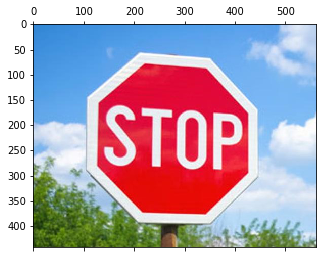

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from numpy import expand_dims
import os.path as osp
import numpy as np
import cv2

img_path = '/content/gdrive/MyDrive/sign_traffic_images/stop_ROI.jpg'

img = tf.keras.preprocessing.image.load_img(
    img_path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest"
)

array = tf.keras.preprocessing.image.img_to_array(img, data_format=None, dtype=None)

import matplotlib.pyplot as plt

plt.matshow(img)

My model says: Stop


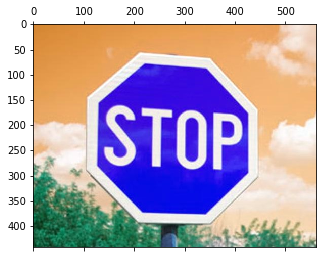

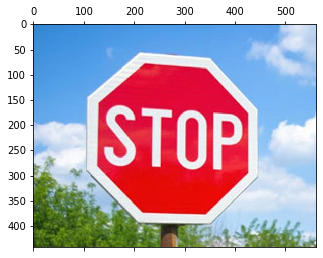

In [ ]:
img_array = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
plt.matshow(img_array)

# La imagen inicialmente se carga en formato BGR, y necesito
# formato RGB

img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

plt.matshow(img_array)

new_array = cv2.resize(img_array, (180, 180))

# 180x180 con 3 canales
new_array = new_array.reshape(-1, 180, 180, 3)

# Muestro la imagen resultante

prediction = model.predict(new_array)
print(f"My model says: {class_names[prediction.argmax()]}")

My model says: Diamond


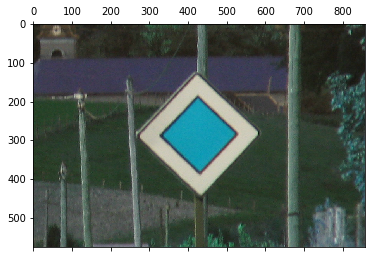

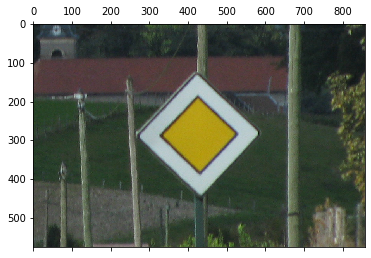

In [ ]:
img_path = '/content/gdrive/MyDrive/sign_traffic_images/diamond.jpg'
img_array = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
plt.matshow(img_array)

# La imagen inicialmente se carga en formato BGR, y necesito
# formato RGB

img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

plt.matshow(img_array)

new_array = cv2.resize(img_array, (180, 180))

# 180x180 con 3 canales
new_array = new_array.reshape(-1, 180, 180, 3)

# Muestro la imagen resultante

prediction = model.predict(new_array)
print(f"My model says: {class_names[prediction.argmax()]}")

My model says: Prohibition


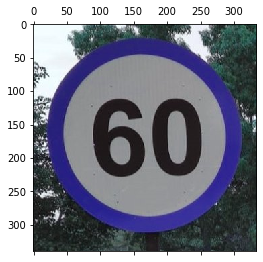

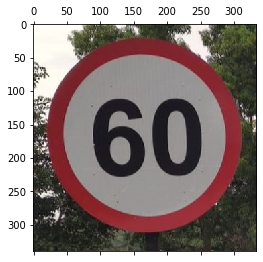

In [ ]:
img_path = '/content/gdrive/MyDrive/sign_traffic_images/speed_limit_ROI.png'
img_array = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
plt.matshow(img_array)

# La imagen inicialmente se carga en formato BGR, y necesito
# formato RGB

img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

plt.matshow(img_array)

new_array = cv2.resize(img_array, (180, 180))

# 180x180 con 3 canales
new_array = new_array.reshape(-1, 180, 180, 3)

# Muestro la imagen resultante

prediction = model.predict(new_array)
print(f"My model says: {class_names[prediction.argmax()]}")

My model says: Giveway


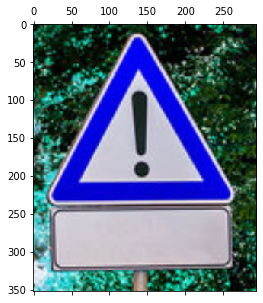

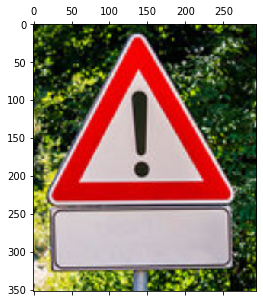

In [ ]:
img_path = '/content/gdrive/MyDrive/sign_traffic_images/warning.png'
img_array = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
plt.matshow(img_array)

# La imagen inicialmente se carga en formato BGR, y necesito
# formato RGB

img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

plt.matshow(img_array)

new_array = cv2.resize(img_array, (180, 180))

# 180x180 con 3 canales
new_array = new_array.reshape(-1, 180, 180, 3)

# Muestro la imagen resultante

prediction = model.predict(new_array)
print(f"My model says: {class_names[prediction.argmax()]}")